# Project 3. Limited time training

 In project 3, you're going to improve your network under the limitation of time, specifically 10 minutes. You can borrow any structure that you consider viable, but pretrained models are **NOT allowed**.

**Hint**: Most of the popular networks can't converge in 10 minutes, so if you decide to borrow any, you'd have to trim the network a little to fit into the time frame.

## 1. Preparation

This project is time limited, we need to make sure that your hardwares are exactly the same, try the following code, if you see 'GPU correct, proceed.', you can continue the project, otherwise, click the dropdown at the upper right corner besides the status bar (RAM, Disk), and go to 'Manage sessions', and terminate the current session, then reconnect, and try the code again, repeat until you see the right message.

In [ ]:
!if [ $(nvidia-smi | grep Tesla | tr -s " " | cut -d' ' -f4) == 'T4' ]; then echo "GPU correct, proceed."; else echo "GPU incorrect, please terminate this session and reconnect again."; fi

GPU correct, proceed.


## 2. Before training

For dataset, we continue to use CIFAR10, in this part, you can configure all of your settings, including data augmentation, model structure, optimizer etc., but don't put any major calculation part in.

### 2.1 Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
import numpy as np

cifar10_train = torchvision.datasets.CIFAR10("CIFAR10", train=True, transform=lambda x: np.array(x, dtype=np.float32).transpose(2,0,1),
                                         target_transform=None, download=True)
cifar10_test = torchvision.datasets.CIFAR10("CIFAR10", train=False, transform=lambda x: np.array(x, dtype=np.float32).transpose(2,0,1),
                                         target_transform=None, download=True)
print(len(cifar10_train))

Files already downloaded and verified
Files already downloaded and verified
50000


### 2.2 Model

**Hint**: Even though pretrained models are not allowed in your final version, you can use pretrained models to determine how well the structure CAN perform and use this as part of your analysis as to determining network structure.

**Model definition**

In [ ]:
import torchvision.models
import torch.nn.functional as F
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet,self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3,padding = 1)
        self.batch1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 64, 3,padding = 1)
        self.batch2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 256, 3,padding = 1)
        self.batch3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 3,padding = 1)
        self.batch4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, 3,padding = 1)
        self.batch5 = nn.BatchNorm2d(1024)
        self.fc1 = nn.Linear(1024 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 10)#Output 10 classes

    def forward(self, x):
        x = self.pool(self.relu1(self.batch1(self.conv1(x))))
        x = self.pool(self.relu1(self.batch2(self.conv2(x))))
        x = self.pool(self.relu1(self.batch3(self.conv3(x))))
        x = self.pool(self.relu1(self.batch4(self.conv4(x))))
        x = self.pool(self.relu1(self.batch5(self.conv5(x))))
        x = x.view(-1, 1024 * 1 * 1)
        x = self.relu1(self.fc1(x))
        x = self.relu1(self.fc2(x))
        x = self.relu1(self.fc3(x))
        x = self.out(x)
        return x
net = MyNet().cuda()

**Analysis tools**

In [ ]:
def testset_precision(net, testset):
    net.eval()
    dl = DataLoader(testset, batch_size=512)
    total_count = 0
    total_correct = 0
    for data in dl:
        inputs = data[0].cuda()
        targets = data[1].cuda()
        outputs = net(inputs)
        predicted_labels = outputs.argmax(dim=1)
        comparison = predicted_labels == targets
        total_count += predicted_labels.size(0)
        total_correct += comparison.sum()
    net.train()   
    return int(total_correct) / int(total_count)

print(f'Inital precision: {testset_precision(net, cifar10_test)}')

from IPython import display
import matplotlib.pyplot as plt
import time

class DrawingBoard:
    def __init__(self, names, time_slot=60):
        self.start_time = time.time()
        self.time_slot = time_slot
        self.annotations = []
        self.data = {}
        for name in names:
            self.data[name] = []
    
    def update(self, data_dict):
        for key in data_dict:
            self.data[key].append(data_dict[key])
        current_time = time.time() - self.start_time
        idx = len(self.data[key]) -1
        if len(self.annotations) == 0:
            if current_time > self.time_slot:
                self.annotations.append((idx, current_time))
        elif current_time - (self.annotations[-1][1]//self.time_slot)*self.time_slot > self.time_slot:
            self.annotations.append((idx, current_time))
    
    def draw(self):
        all_keys = list(self.data.keys())
        fig, ax = plt.subplots(nrows=1, ncols=len(all_keys))
        fig.set_figwidth(20)
        for idx in range(len(all_keys)):
            ax[idx].plot(self.data[all_keys[idx]])
            ax[idx].set_title(all_keys[idx])
            for an in self.annotations:
                ax[idx].annotate(f'{int(an[1])}s', xy=(an[0], self.data[all_keys[idx]][an[0]]),
                    xytext=(0, -40), textcoords="offset points",
                    va="center", ha="left",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
        display.clear_output(wait=True)
        plt.show()

Inital precision: 0.0962


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.90)
dataloader = DataLoader(cifar10_train, batch_size=256, shuffle=True,num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 3. Start Training

This is the training part, take advantage of everything you know. In addition to the tips last time, you can also consider data augmentation, short cut structure in ResNet etc.

Basically at this point, nothing is limited except time and pretrained models.

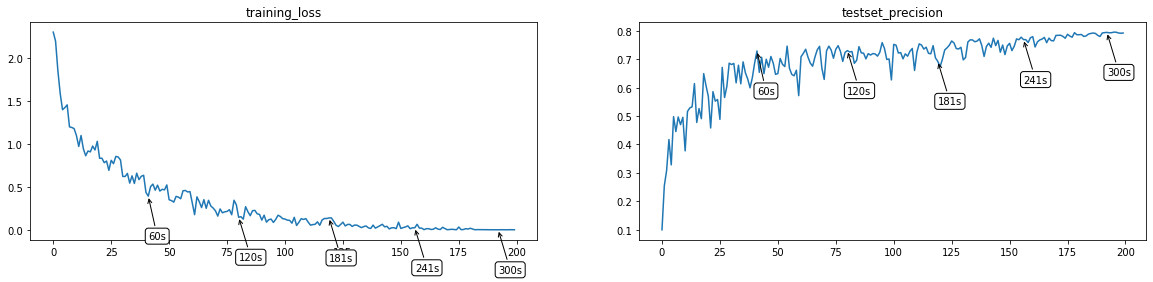

finished


In [ ]:
# modify as you need
import time
import signal
class TimeLimitation:
    def __init__(self, limit):
        self.limit = limit

    def __enter__(self):
        def handler(signum, frame):
            raise NotImplementedError('Time\'s up')
        signal.signal(signal.SIGALRM, handler)
        signal.alarm(self.limit)

    def __exit__(self, exc_type, exc_val, exc_tb):
        signal.alarm(0)


with TimeLimitation(600): # don't forget the indentation
    print('start training')
    db = DrawingBoard(['training_loss', 'testset_precision'], time_slot=60)
    for epoch in range(20):
        for iter, data in enumerate(dataloader):
            inputs = data[0].cuda()
            targets = data[1].cuda()
            outputs = net(inputs)

            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            if iter % 20 == 0:
                db.update({'training_loss':loss.item(), 'testset_precision': testset_precision(net, cifar10_test)})
                db.draw()
        scheduler.step()

    print('finished')

# Marking Scheme

*   Code implementation: 30%


> * Successfully run through the whole project: 10%
> * Code implementation quality: 20% (including performance)

*   PDF report: 50%

> * Overview, introduction to the network structure etc.: 10%
> * Analysis and improvements: 40%

*   Presentation: 20%

> * Overall demonstration: 10%
> * Unfolding analysis: 10%